In [11]:
import numpy as np
import matplotlib.pyplot as plt
import multiresolutionimageinterface as mir
from skimage import transform
import skimage.morphology as mp
import cv2
import os
def write_mask(id, thresh = .4):
    print(id)
    step_size= 256
    writer = mir.MultiResolutionImageWriter()
    if not os.path.exists('test/mask4'):
        os.mkdir('test/mask4/')
    writer.openFile(f'test/mask4/{id}_mask.tiff')
    import openslide
    reader = openslide.OpenSlide(f'/home/data/ACDC/test/{id}.tif')
    #print(reader.dimensions)
    writer.setTileSize(step_size)
    writer.setCompression(mir.LZW)
    writer.setDataType(mir.UChar)
    writer.setInterpolation(mir.NearestNeighbor)
    writer.setColorType(mir.Monochrome)
    writer.writeImageInformation(reader.dimensions[0],reader.dimensions[1])
    maxy = reader.dimensions[0]
    maxx = reader.dimensions[1]
    #print(maxx,maxy)
    for rp in os.listdir(f'test/{id}/'):
        #print(rp)
        if not rp.endswith('.npy'):
            continue
        [xmin, ymin, xmax, ymax]=map(int, rp[:-4].split('_'))
#         xmin += 96
#         ymin += 96
#         xmax -= 96
#         ymax -= 96
        prediction = np.load(f'test/{id}/'+rp)
        #prediction = cv2.morphologyEx(prediction, cv2.MORPH_CLOSE, np.ones((7,7)))
        #prediction = cv2.morphologyEx(prediction, cv2.MORPH_OPEN, np.ones((3,3)))
        prediction = mp.remove_small_objects(prediction>thresh, min_size=7, connectivity=1)
        prediction = mp.remove_small_holes(prediction>thresh,min_size=7)  

        post = np.zeros((xmax-xmin, ymax-ymin))
        for i in range(prediction.shape[0]):
            for j in range(prediction.shape[1]):
                post[122+i*32, 122+j*32]=prediction[i,j]
        post = mp.dilation(post, mp.square(33))>thresh
        
#         post = cv2.morphologyEx(post, cv2.MORPH_OPEN, np.ones((33,33)))
#         post = cv2.morphologyEx(post, cv2.MORPH_CLOSE, np.ones((65,65)))
#         post = (post>0.5)
#         post = mp.remove_small_objects(post, min_size=100, connectivity=1)
#         post = mp.remove_small_holes(post,min_size=100)      
#         post = post>0.5
        #print("post processed...")
        
        post = post.astype('ubyte')
        kx = xmin%step_size
        kx2 = step_size-xmax%step_size
        ky = ymin%step_size
        ky2 = step_size-ymax%step_size
        new_xmin = xmin - xmin%step_size
        new_xmax = xmax - xmax%step_size + step_size
        new_ymin = ymin - ymin%step_size
        new_ymax = ymax - ymax%step_size + step_size
        new_post = np.zeros((new_xmax-new_xmin,new_ymax-new_ymin)).astype("ubyte")
        new_post[kx:-kx2,ky:-ky2]=post
        post = new_post
        for x in range(xmin,min(maxx, xmin+post.shape[0])-step_size, step_size):
            for y in range(ymin,min(maxy, ymin+post.shape[1])-step_size, step_size):
                write = post[(x-xmin):(x-xmin+step_size),(y-ymin):(y-ymin+step_size)]
                writer.writeBaseImagePartToLocation(write.flatten(), y, x)              
    writer.finishImage()

In [12]:
for i in range(1,51):
    i=19
    write_mask(i, thresh=1)
    break

19


/home/power/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:207: UserWarning: the min_size argument is deprecated and will be removed in 0.16. Use area_threshold instead.
  "0.16. Use area_threshold instead.")


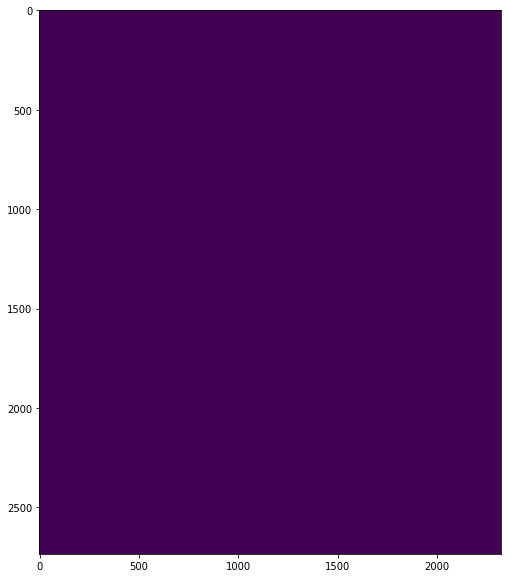

In [14]:
import openslide
import multiresolutionimageinterface as mir
import matplotlib.pyplot as plt
rmask = mir.MultiResolutionImageReader()
rmask = rmask.open('test/mask4/19_mask.tiff')
width, height = rmask.getLevelDimensions(3)
mask = rmask.getUCharPatch(0, 0, width, height, 3)
plt.figure(figsize=(10,10))
plt.imshow(mask[:,:,0])